In [1]:
from collections import defaultdict
import tarfile
import random

tar_gz_path = 'twitter.tar.gz' # need to install Twitter social circle and place direct file into code repository

# Directed adjacency List of entire graph
directed_adjacency_list = defaultdict(set)

with tarfile.open(tar_gz_path, 'r:gz') as tar:
    for member in tar.getmembers():
        if member.name.endswith('.edges'):
            with tar.extractfile(member) as f1:
                for l in f1:
                    nodes = l.decode('utf-8').split('\n')[0].split(' ')
                    u, v = int(nodes[0]), int(nodes[1]) # u follows v in directed edges
                    directed_adjacency_list[u].add(v)

dalTrain, dalTest, dalValidate = defaultdict(set), defaultdict(set), defaultdict(set) # directed adjacency list train, test, validate sets
ualTrain, ualTest, ualValidate = defaultdict(set), defaultdict(set), defaultdict(set) # undirected adjacency list; much easier to make/split when doing the train/test/validate split for sizing reasons


for node in directed_adjacency_list:
    neighbors = list(directed_adjacency_list[node])
    random.shuffle(neighbors)
    neighborsTrain, neighborsTest, neighborsValidate = neighbors[:int(len(directed_adjacency_list[node]) * 0.6)], neighbors[int(len(directed_adjacency_list[node]) * 0.8):], neighbors[int(len(neighbors) * 0.6):int(len(neighbors) * 0.8)]
    dalTrain[node].update(neighborsTrain)
    dalTest[node].update(neighborsTest)
    dalValidate[node].update(neighborsValidate)

    for neighbor in neighborsTrain:
        ualTrain[node].add(neighbor)
        ualTrain[neighbor].add(node)

    for neighbor in neighborsTest:
        ualTest[node].add(neighbor)
        ualTest[neighbor].add(node)

    for neighbor in neighborsValidate:
        ualValidate[node].add(neighbor)
        ualValidate[neighbor].add(node)

In [ ]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

correct, total = 0, 0
nodesSet = set(directed_adjacency_list.keys())
# Testing for directed graph only
for node1 in dalTest: # get each node that has an associated part in test set
    similarities = []
    for node2 in nodesSet - dalTrain[node1]: # Compute Jaccard of all neighbors unlinked
        similarities.append(Jaccard(dalTrain[node1], dalTrain[node2]))
    similarities.sort(reverse=True)
    recommendations = similarities[:int(len(dalTrain[node]) / 0.8)] # Top (# missing) recommendations for each node
    for recommendation in recommendations:
        if recommendation in dalTest[node]:
            correct += 1 # for accuracy measurement
        total += 1 # for accuracy measurement

accuracy = correct / total

KeyboardInterrupt: 

In [31]:
import tarfile
import os

def parse_featnames(file):
    featnames = {}
    for line in file:
        index, label = line.decode('utf-8').strip().split(' ')
        featnames[int(index)] = label
    return featnames

def load_features(file):
    features = {}
    for line in file:
        parts = line.decode('utf-8').strip().split(' ')
        node_id = int(parts[0])
        features[node_id] = list(map(int, parts[1:]))
    return features

def process_tar_gz(tar_gz_path):
    all_features = {}
    all_featnames = {}

    with tarfile.open(tar_gz_path, 'r:gz') as tar:
        for member in tar.getmembers():

            if member.name.endswith('.featnames'):
                node_id = int(member.name.split('/')[1].split('.')[0])  # Extract nodeID
                with tar.extractfile(member) as f:
                    featnames = parse_featnames(f)
                    all_featnames[node_id] = featnames
            elif member.name.endswith('.feat'):
                node_id = int(member.name.split('/')[1].split('.')[0])  # Extract nodeID
                featnames = all_featnames.get(node_id, {})
                if featnames:  # Check if featnames for this node were already parsed
                    with tar.extractfile(member) as f:
                        features = load_features(f)
                        all_features.update(features)

    return all_features, all_featnames


In [32]:
def create_global_feature_index(all_featnames):
    unique_features = set()
    for featnames in all_featnames.values():
        unique_features.update(featnames.values())

    feature_index = {feature: idx for idx, feature in enumerate(unique_features)}
    return feature_index

def encode_features(node_features, feature_index):
    from scipy.sparse import csr_matrix

    encoded_features = {}
    for node_id, features in node_features.items():
        # Create an empty vector of size equal to the number of unique features
        vector = [0] * len(feature_index)

        # Assume `features` are indices already pointing to where features are 1
        for idx, f in enumerate(features):
            if f == 1:
                vector[idx] = 1  # Directly use feature indices from `features` list

        # Convert list to sparse CSR matrix
        encoded_features[node_id] = csr_matrix(vector)

    return encoded_features

In [33]:
all_features, all_featnames = process_tar_gz("./twitter.tar.gz")  # Assume this function is defined to extract raw features

# Create a consistent feature index
feature_index = create_global_feature_index(all_featnames)

# Encode all features
encoded_features = encode_features(all_features, feature_index)

In [34]:
encoded_features[list(encoded_features.keys())[9]].nonzero()

(array([0, 0, 0, 0]), array([ 33,  85, 215, 216]))

In [35]:
import numpy as np
from scipy.sparse import vstack

def sum_feature_occurrences(encoded_features):
    # Stack all feature matrices vertically
    all_features_matrix = vstack(list(encoded_features.values()))

    # Sum occurrences along the column, resulting in a total count for each feature
    feature_counts = np.array(all_features_matrix.sum(axis=0)).flatten()  # Convert to 1D array
    return feature_counts

def map_indices_to_names(feature_index):
    # Reverse the feature_index to get names from indices
    index_to_name = {index: name for name, index in feature_index.items()}
    return index_to_name

def display_most_common_features(feature_counts, index_to_name, top_n=10):
    # Sort the features by count and retrieve the top_n
    most_common_indices = np.argsort(feature_counts)[::-1]  # Indices of the most common features

    print("Most Common Features:")
    for idx in most_common_indices:
        if feature_counts[idx] == 0:
            continue
        feature_name = index_to_name.get(idx, "Unknown Feature")
        print(f"{feature_name}: {feature_counts[idx]} occurrences")



In [36]:
# Step 1: Sum the occurrences of each feature across all nodes
feature_counts = sum_feature_occurrences(encoded_features)

# Step 2: Map feature indices back to their names
index_to_name = map_indices_to_names(feature_index)

# Step 3: Display the top 10 most common features
display_most_common_features(feature_counts, index_to_name, top_n=10)


Most Common Features:
@AutodeskCare: 1863 occurrences
@Jeff: 1515 occurrences
#NYRangers: 1214 occurrences
@Cadrieu: 1106 occurrences
#mexicosuenacontelehit: 1072 occurrences
@SgtHarvey:: 1018 occurrences
@SketchUp.: 1010 occurrences
@clash_music:: 1001 occurrences
@nbccommunity.: 995 occurrences
@sungsookcook: 992 occurrences
@Astma: 988 occurrences
@Shidosha: 988 occurrences
@luistolentino: 988 occurrences
@vespertinemusic:: 982 occurrences
@miguelrios): 978 occurrences
#Asian: 969 occurrences
#D3.: 963 occurrences
@karayu: 962 occurrences
@kophoogte: 955 occurrences
@BenjRubenstein: 955 occurrences
#hater: 952 occurrences
@philipbrasor:: 951 occurrences
@warbyparker!: 949 occurrences
@daniel_levine: 949 occurrences
#Unsupervised: 944 occurrences
@ScubyUK: 943 occurrences
@gmartcomics:: 943 occurrences
@cooper_smith: 943 occurrences
@chippy:: 942 occurrences
@Minnesota: 941 occurrences
@joyent: 940 occurrences
#Prayer: 939 occurrences
@Zombologist: 935 occurrences
@abrahamvegh: 932 o

In [37]:
import pandas as pd

# Convert dictionary to DataFrame
df = pd.DataFrame(list(feature_index.items()), columns=['Feature', 'Index'])
# Save to CSV
df.to_csv("feature_index.csv", index=False)

C:\Users\mboyk\AppData\Local\Temp\ipykernel_19148\166272771.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [38]:
import csv
    
# Open a CSV file for writing
with open("encoded_features.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["NodeID", "Index", "Value"])  # Header

    # Iterate over each node's CSR matrix
    for node_id, csr_matrix in encoded_features.items():
        coo_matrix = csr_matrix.tocoo()  # Convert CSR to COO format
        for i, j, v in zip(coo_matrix.row, coo_matrix.col, coo_matrix.data):
            writer.writerow([node_id, j, v])  # Save node_id, feature index, and value

In [ ]:
def load_feature_index_from_csv(filename="feature_index.csv"):
    df = pd.read_csv(filename)
    return dict(zip(df['Feature'], df['Index']))

feature_index = load_feature_index_from_csv()


In [ ]:
from scipy.sparse import coo_matrix, csr_matrix

def load_encoded_features_from_csv(filename="encoded_features.csv"):
    df = pd.read_csv(filename)
    encoded_features = {}

    for node_id, group in df.groupby('NodeID'):
        # Rebuild COO matrix and convert to CSR
        csr = coo_matrix((group['Value'], (group['Index'], group['Index'])), shape=(1, max(df['Index']) + 1)).tocsr()
        encoded_features[node_id] = csr

    return encoded_features

encoded_features = load_encoded_features_from_csv()


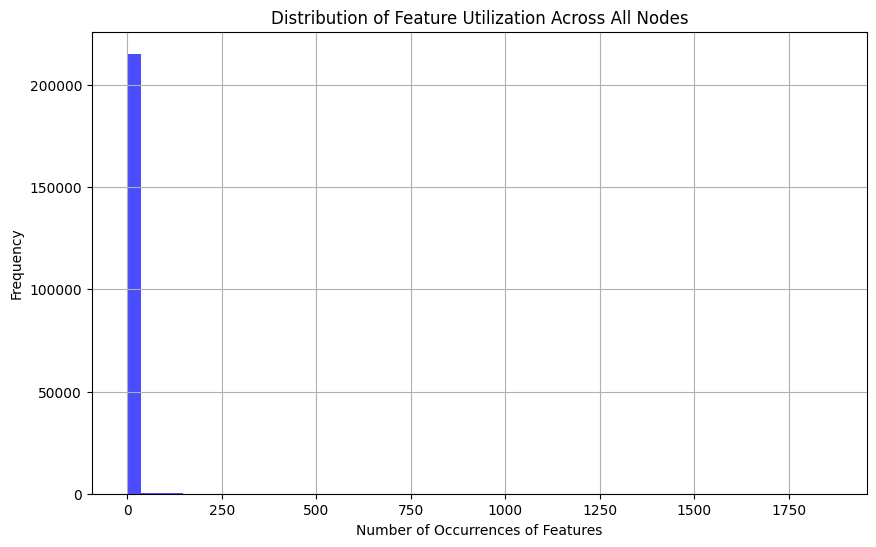

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_distribution(feature_counts):
    plt.figure(figsize=(10, 6))
    plt.hist(feature_counts, bins=50, color='blue', alpha=0.7)
    plt.title('Distribution of Feature Utilization Across All Nodes')
    plt.xlabel('Number of Occurrences of Features')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Assuming feature_counts is already calculated
plot_feature_distribution(feature_counts)


In [ ]:
def analyze_feature_connections(directed_adjacency_list, encoded_features):
    connected_shared_features = []
    unconnected_shared_features = []
    
    # Generate a list of all nodes for sampling unconnected pairs
    all_nodes = list(encoded_features.keys())
    
    # Analyze connected pairs
    for node, neighbors in directed_adjacency_list.items():
        if node in encoded_features:
            node_features = set(encoded_features[node].nonzero()[1])
            for neighbor in neighbors:
                if neighbor in encoded_features:
                    neighbor_features = set(encoded_features[neighbor].nonzero()[1])
                    shared_features = node_features.intersection(neighbor_features)
                    connected_shared_features.append(len(shared_features))
                    
    # Analyze random unconnected pairs (same number as connected for fairness)
    import random
    for _ in range(len(connected_shared_features)):
        node = random.choice(all_nodes)
        neighbor = random.choice(all_nodes)
        if node != neighbor and neighbor not in directed_adjacency_list[node]:
            node_features = set(encoded_features[node].nonzero()[1])
            neighbor_features = set(encoded_features[neighbor].nonzero()[1])
            shared_features = node_features.intersection(neighbor_features)
            unconnected_shared_features.append(len(shared_features))

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.hist(connected_shared_features, bins=30, alpha=0.5, label='Connected', color='green')
    plt.hist(unconnected_shared_features, bins=30, alpha=0.5, label='Unconnected', color='red')
    plt.xlabel('Number of Shared Features')
    plt.ylabel('Frequency')
    plt.title('Distribution of Shared Features Among Connected vs. Unconnected Node Pairs')
    plt.legend()
    plt.grid(True)
    plt.show()

    return connected_shared_features, unconnected_shared_features

# Call the function
connected_shared_features, unconnected_shared_features = analyze_feature_connections(directed_adjacency_list, encoded_features)
